# 3D7 Finite element method - laboratory notebook

---
---


## Create a copy before you begin


1. Click **Copy to Drive** using the icon on the top to create a copy of this notebook in your Cambridge Google Drive.

<img src='https://docs.google.com/uc?export=download&id=1c5aWac_AK4AUA9KvlROIJS9vca0UJUfL' height=150/>

2. Click **File > Locate in Drive** to locate your own copy. Rename the notebook appropriately.
3. Do not work directly in this original notebook as you will not be able to save in this original notebook.



## Introduction to Google Colab and Jupyter Notebook

We will use [Jupyter Notebook](https://jupyter.org/) hosted by Google Colab for interactive coding. To use this notebook effectively, you must know the following:

1. Jupyter Notebook has two types of cell i.e. *text* cell and *code* cell. You can typeset and format a *text* cell to provide information about your codes. *Code* cells are executable using the built-in Python interpreter. Each *code* cell has a "Play" icon on its left. To execute a *code* cell, either click the "Play" button or press "Shift" + "Enter" with your keyboard.
2. Google Colab has a built-in Python interpreter and runs on Ubuntu OS. Any Python packages that you install here stay in the cloud. Each time you close and reopen this Notebook, you have to run again all *code* cells including the cells that install the Python packages.
3. Always run *code* cells sequentially i.e. from top to bottom. After you execute successfully a *code* cell, a green tick and a number e.g. [1] or [2] indicating the execution sequence will appear on its left.
4. Save your notebook by clickling **File > Save** or using the keyboard shortcut "Ctrl" + "s".
5. After running a *code* cell, if you wish to clear the output, you can click the cell, then hover your mouse to the top right of the cell and find **More cell actions > Clear output**. Clearing the output helps keep your notebook organised especially for *code* cells that install Python packages.
6. If you wish to clear all Python variables so that the notebook returns to the initial state, click **Runtime > Factory reset runtime**. This should save you time from closing and re-opening your notebook.
7. You can always re-create a copy from the original notebook should you run into bugs that you cannot fix.
8. There is a table of contents on the left to help you navigate the notebook.

More information about Google Colab can be found in [Google Colab's Frequently Asked Questions](https://research.google.com/colaboratory/faq.html).

## Tasks for the lab session

This lab involves performing finite element analyses of a tensioned strip with a circular hole using various meshes. The meshes are generated with *gmsh* and the finite element analysis is performed with *FEniCS*.

Before performing the finite element analyses, explore the following points to familiarise yourself with the notebook. Each issue is further elaborated at relevant places in the notebook. Allocate around 30 minutes for this exploration.

*   **P1**: Find out how to refine the mesh and grade it towards high stress gradients.  
*   **P2**: Find out how to implement the weak form if the prescribed traction is changed to prescribed displacement on the rightmost edge of the strip.
*   **P3**: State two factors that can increase the number of degrees of freedom and the size of the assembled finite element linear system.
*   **P4**: Visually examine the relationship between the magnitude of the applied traction and the resulting stress field across the plate.

After exploring the notebook, see the Section 3 of the handout for specific finite element analyses you should perform and report. The report should cover only this second part of the lab and not the  exploration phase.

---
# Step 1. Installing [FEniCS](https://fenicsproject.org/)

FEniCS is an open-source finite element package with a Python interface. Run the following cell to install FEniCS on Google Colab:

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

---
# Step 2. Installing [Gmsh](https://gmsh.info/)

Gmsh is an open-source finite element mesh generator with built-in computer-aided design (CAD) engine. You can create a geometry and subsequently mesh it. Gmsh has a graphics user interface and a Python interface. We use here Gmsh's Python interface.

In [2]:
!pip3 install gmsh==4.7.0
import sys
sys.path += ['/usr/local/lib/python3.7/site-packages/gmsh-4.7.0-Linux64-sdk/lib']

---
# Step 3. Creating and meshing the geometry

The geometry is a quarter of a strip. See Figure 1 in the labaratory handout for the dimensions. After defining the geometry a mesh is generated.  

In [3]:
# Import some packages: gmsh, the sys package to allow command line commands to be executed from the Python interpreter and the math package
import gmsh
import sys
import math

# Initialise gmsh
gmsh.initialize(sys.argv)
# Ask gmsh to display information in the terminal
gmsh.option.setNumber("General.Terminal", 1)
# Select the gmsh file format
gmsh.option.setNumber("Mesh.MshFileVersion", 2.0)

# Create a model and name it "PlateSymmetric"
model = gmsh.model
model.add("PlateSymmetric")

# Define the geometry and mesh parameters
L = 150;  # half-length of the plate
w = 50;   # half-width of the plate
r = 14.8; # radius of the hole
hmin = 9; # min element size
hmax = 9; # max element size

# Create Points to define the geometry
holecenter        = model.geo.addPoint(0, 0, 0, hmin, 1)
holeedge1         = model.geo.addPoint(r, 0, 0, hmin, 2)
bottomrightcorner = model.geo.addPoint(L, 0, 0, hmax, 3)
toprightcorner    = model.geo.addPoint(L, w, 0, hmax, 4)
topleftcorner     = model.geo.addPoint(0, w, 0, hmax, 5)
holeedge2         = model.geo.addPoint(0, r, 0, hmin, 6)

# Create straight lines connecting the points
lines = []
lines.append(model.geo.addLine(2, 3, 1))
lines.append(model.geo.addLine(3, 4, 2))
lines.append(model.geo.addLine(4, 5, 3))
lines.append(model.geo.addLine(5, 6, 4))

# Create a circle arc
lines.append(model.geo.addCircleArc(6, 1, 2))

# Define a loop by combining the lines and the circle arc
curveloop = model.geo.addCurveLoop([1,2,3,4,5])
# Define a surface inside the loop
disk = model.geo.addPlaneSurface([curveloop])

# Synchronize the CAD kernel with the gmsh model
gmsh.model.geo.synchronize()
# Create the 2D mesh
model.mesh.generate(2)
# Write the mesh in a .msh file
gmsh.write("mesh.msh")
# Finalize gmsh
gmsh.finalize()

> **P1**: Notice the parameters *hmin* and *hmax* in the cell above. Adjust these parameters to see their effect on the finite element mesh.

To visualise the mesh the file **mesh.msh** is converted into **mesh2.xml**.

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 147 vertices
Found all vertices
Expecting 246 cells
Found all cells
Conversion done


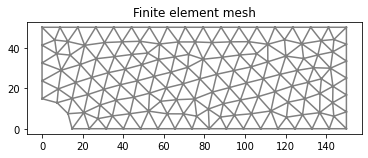

In [4]:
from fenics import *
from dolfin_utils.meshconvert import meshconvert
meshconvert.convert2xml("mesh.msh", "mesh2.xml", "gmsh")

mesh = Mesh("mesh2.xml")
plot(mesh, title="Finite element mesh")

> **P1**: When you change the parameters *hmin* and *hmax* remember to visualise the new mesh.



The number of triangular elements in the mesh is queried as follows.

In [5]:
print(mesh.num_cells())

246


---
# Step 4. Defining the elasticity problem

The finite element equations are obtained by discretising the weak form of the elasticity equations, or the principal of virtual work. 

The applied stress is the total applied force ($10 \times 10^3$ N) divided by the cross-sectional area of the strip ($100$ mm $\times$ $1.7$ mm).

In [6]:
applied_stress = 58             # applied normal stress (N/mm^2)

The Young's modulus $E$ and the Poisson's ratio $ν$ for aluminum are found in the Structures Data book.

In [7]:
E  = Constant(70000)            # Young's modulus (MPa i.e. N/mm^2)
nu = Constant(0.33)             # Poisson's ratio

As outlined in the handout the strain $\varepsilon$ is the symmetric gradient. The strain $\varepsilon$ and stress $\sigma$ are related through Hooke's law. The Hooke's law for plane stress can be expressed as given below.

In [8]:
def eps(v):
    return sym(grad(v))

In [9]:
def sigma(v):
    return (E*nu/(1.0-nu*nu))*tr(eps(v))*Identity(2) + (E/(1.0+nu))*eps(v)

Next, the Neumann boundary is defined. Recall that a traction, i.e. stress, is applied along the right edge of the strip. 

In [10]:
# return true if a vertex is on the right edge of the strip (x=L)
class IsTractionBoundary(SubDomain):
    def inside(self, x, on_boundary):
		    return near(x[0], L)
      
# get all boundary nodes and apply a scalar function over these vertices
mesh_boundary_bool = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
# initialise all boundary nodes as 0
mesh_boundary_bool.set_all(0)

# set boundary nodes that lie on the right edge as 1
IsTractionBoundary().mark(mesh_boundary_bool, 1)
# define a surface integral based on this function
ds = Measure("ds")(subdomain_data=mesh_boundary_bool)

Recall that the weak form is given by

>$$ \int_\Omega (\mathbf{\nabla}_S \mathbf w)^T \mathbf{\sigma} (\mathbf u) \, d\Omega = \int_{\Gamma_t} \mathbf w^T \overline{\mathbf t} \, d \Gamma_t   $$

where $\Omega$ is the domain, $\Gamma_t$ is the traction boundary (in this case, the right edge of the strip), $\mathbf{w}=\left[w_x\, w_y\right]^T$ is the vector of test functions, $\mathbf{\nabla}_S$ is the symmetric gradient, $ \mathbf{\sigma} = \left[\sigma_{xx}\, \sigma_{yy} \, \sigma_{xy} \right]^T$ is the stress vector and $ \overline{\mathbf t} = \left[\overline{ t}_x\,\,\overline{ t}_y \right]^T$ is the applied traction vector. 

In [11]:
s  = Constant((applied_stress, 0.0))                 # vector of applied stress
V  = VectorFunctionSpace(mesh, 'Lagrange', degree=2) # shape functions
u_ = TrialFunction(V)                                # trial function
w_ = TestFunction(V)                                 # test function
a  = inner(sigma(u_), eps(w_))*dx                    # internal virtual work
l  = inner(s, w_)*ds(1)                              # external virtual work

Next, the Dirichlet boundary is defined. 

In [12]:
# return true if the node is on the left domain edge
def is_on_left(x, on_boundary):
    return near(x[0], 0.)

# return true if the node is on the bottom domain edge
def is_on_bottom(x, on_boundary):
    return near(x[1], 0.)

# return true if the node is on the right domain edge
def is_on_right(x, on_boundary):
		return near(x[0], L)

# define the Dirichlet boundary 
bcx = DirichletBC(V.sub(0), Constant((0.)), is_on_left)
bcy = DirichletBC(V.sub(1), Constant((0.)), is_on_bottom)
bc = [bcx, bcy]

> **P2**: If on the right domain edge a displacement instead of a traction is prescribed, what needs to be changed? Hints:
1.   Uncomment the code below and experiment.
2.   Note that for the same point it is **not possible** to prescribe both displacement and traction.

In [13]:
# displacement = 0.5                  
# bc_displacement = DirichletBC(V.sub(0), Constant((displacement)), is_on_right)
# bc = [bcx, bcy, bc_displacement]                                     

---
# Step 5. Solving the linear system of equations

The finite element discretisation of the weak form yields a (sparse) linear system of equations, which can be efficiently solved.

In [14]:
u = Function(V, name="Displacement")
solve(a == l, u, bc)

The finite element solution is best examined visualising the displacement field.

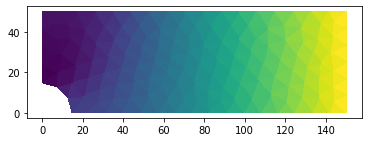

In [15]:
plot(u, mode="displacement")

The size of the displacement vector is equal to the number of degrees of freedom.

In [16]:
u.vector()[:].size

1078



> **P3** The higher the number of degrees of freedom the longer it takes to solve the linear system of equations.  Can you state two factors that affect the number of degrees of freedom? Hints:
1.   Experiment with the number of elements.
2.   Experiment with the polynomial degree of the Lagrange shape functions.




---
#Step 6. Postprocessing

Finite element analysis is more than just pretty plots! For postprocessing the Python modules [matplotlib](https://matplotlib.org/) and [numpy](https://numpy.org/) can be used. 

The stress near the hole boundary is inquired as follows.

In [17]:
Vsig = TensorFunctionSpace(mesh, "DG", degree=1) # define finite element interpolation for the stress
sig = Function(Vsig, name="Stress")              # define stress function
sig.assign(project(sigma(u), Vsig))              # project sigma(u) onto the corresponding basis of shape functions
print("Stress at (0,R):", sig(0.001, r+0.001))   # print the stress in the vicinity of the hole

Stress at (0,R): [151.87129916   0.21817623   0.21817623  20.89016217]


The isocontour of the stress component $\sigma_{xx}$ is plotted as follows.

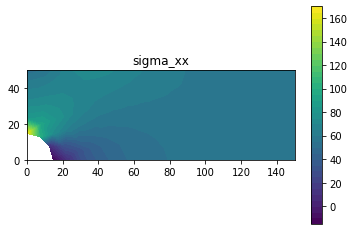

In [18]:
from matplotlib import pyplot
stressplot = plot(sig[0, 0], wireframe=True, title="sigma_xx") 
pyplot.colorbar(stressplot)

> **P4**: What do you notice from the above stress field? Does the distribution of the stress depend on the magnitude of the applied traction? Hint: increase the applied traction and visualise again the stress field.

To compute the stress concentration factor the stress is divided by the applied traction near the right domain boundary.

In [19]:
sigma0 = sig(L, 0)[0]                               # define the horizontal stress near the right domain boundary
print(sigma0)                                       # check if this agrees with the traction boundary condition
sig_rescaled = Function(Vsig, name="Stress")
sig_rescaled.assign(project(sigma(u)/sigma0, Vsig)) # define the rescaled stress

58.00571277321013


To gain further insight the stress concentration factor along certain lines in the domain is plotted as follows.

> Do not use these plots directly in your report. The plots here are only for initial qualitative checks. Follow Step 7 below to export the results and to create plots for your report.




In [20]:
# import the numpy and math packages.
import numpy as np 
import math
# define sets of horizontal and vertical coordinates
n=math.floor(w/4)
x = np.linspace(r+0.01,L,n)
y = np.linspace(r+0.01,w,n)

In [21]:
# define horizontal and vertical rescaled stress profile along the leftmost and bottom edge of the domain
sig_xx_horizontalprofile = [sig_rescaled(xi, 0.)[0] for xi in x]
sig_xx_verticalprofile = [sig_rescaled(0., yi)[0] for yi in y]
sig_yy_horizontalprofile = [sig_rescaled(xi, 0.)[3] for xi in x]
sig_yy_verticalprofile = [sig_rescaled(0., yi)[3] for yi in y]

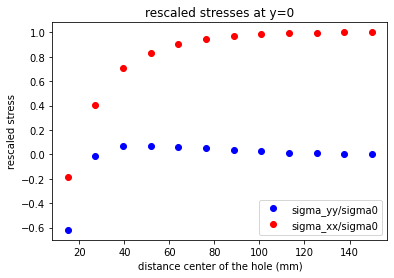

In [22]:
# plot the rescaled stress profiles along the bottom edge of the domain (y=0)
import matplotlib.pyplot as plt
plt.plot(x,sig_yy_horizontalprofile,'bo',label='sigma_yy/sigma0')
plt.plot(x,sig_xx_horizontalprofile,'ro',label='sigma_xx/sigma0')
plt.ylabel("rescaled stress")
plt.xlabel("distance center of the hole (mm)")
plt.title("rescaled stresses at y=0")
plt.legend()

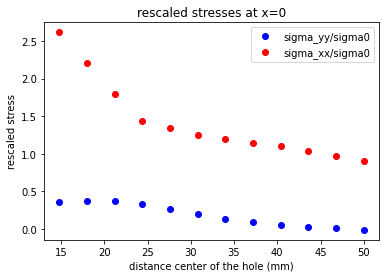

In [23]:
# plot the rescaled stress profiles along the leftmost edge (x=0)
import matplotlib.pyplot as plt
plt.plot(y,sig_yy_verticalprofile,'bo',label='sigma_yy/sigma0')
plt.plot(y,sig_xx_verticalprofile,'ro',label='sigma_xx/sigma0')
plt.ylabel("rescaled stress")
plt.xlabel("distance center of the hole (mm)")
plt.title("rescaled stresses at x=0")
plt.legend()

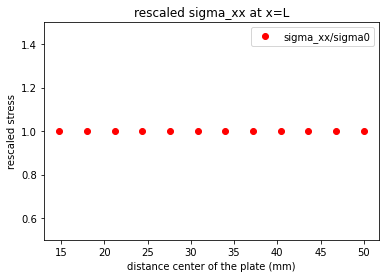

In [24]:
# plot the rescaled stress along the rightmost edge and check if the value is equal to 1
bcsy = [sig_rescaled(L, yi)[0] for yi in y]
plt.plot(y,bcsy,'ro',label='sigma_xx/sigma0')
plt.ylabel("rescaled stress")
plt.xlabel("distance center of the plate (mm)")
plt.title("rescaled sigma_xx at x=L")
plt.ylim(0.5,1.5)
plt.legend()

Extract nodal stress values to obtain the maximum $\sigma_{xx}$, minimum $\sigma_yy$, and maximum von Mises stress. 

> Write a function to compute von Mises stress from the stress components at each nodes.

In [25]:
# list of mesh coordinates
allNodes = mesh.coordinates()

# scaled normal stress at all nodes
sig_xx_all = [sig_rescaled(xi)[0] for xi in allNodes]
sig_yy_all = [sig_rescaled(xi)[3] for xi in allNodes]

# scaled shear stress at all nodes
sig_xy_all = [sig_rescaled(xi)[1] for xi in allNodes]

print("Maximum sigma_xx is: ", np.max(sig_xx_all))
print("Minimum sigma_yy is: ", np.min(sig_yy_all))

# scaled von Mises stress


Maximum sigma_xx is:  3.375039064876143
Minimum sigma_yy is:  -1.229502383205531


---
# Step 7. Exporting the result for post-processing

The finite element results are exported for further processing with a third-party software of choice such as Matlab, Python and Excel.

## Step 7a. Mount your google drive and export results

To export the results, first your Cambridge Google Account needs to authorised. Make sure that you use the same Cambridge Google Account. The authorisation proceeds as follows:

1. Run the *code* cell below. A message will pop up.
2. Click **Connect to Google Drive**.
3. Select which Google account to proceed. Choose your Cambridge Google account.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, create a folder with the name **3D7** in your Google Drive. After that, run the following *code* cell to go to the folder directory.

In [41]:
%cd /content/drive/My\ Drive/3D7

/content/drive/My Drive/3D7


You can now save your rescaled stress profiles as .txt files. The block of code below will create two files. Each of these files has two rows. The first row contains the vector of $x$ coordinates in mm whereas the second contains the rescaled stress.

In [28]:
import numpy as np
np.savetxt("stress-yy.txt", (x,sig_yy_horizontalprofile))
np.savetxt("stress-xx.txt", (x,sig_xx_horizontalprofile))

You can use the list command in Ubuntu shell to see if the files have been created.

In [29]:
!ls

mesh_coarse.xml  stress-xx.txt	u_coarse.h5    u_fine.h5
mesh_fine.xml	 stress-yy.txt	u_coarse.xdmf  u_fine.xdmf


---
# Step 8. Further post-processing





The following provides additional guidelines for post-processing the finite element result.

## Step 8a. Computing the norm of the error (for the FTR)

FEniCS has built-in functions to compute errors in different norms. Here, the finite element error is determined by comparing a coarse mesh solution with a fine mesh solution. More details can be found in the FEniCS article [Postprocessing computations](https://fenicsproject.org/pub/tutorial/html/._ftut1020.html) (see the section *Computing convergence rates*.)

> In order to execute the following cells, first save the finote element results obtained using (i) a coarse mesh and (ii) a fine mesh. For each mesh, save the mesh file and the obtained nodal displacements using the cell below. Don't forget to rename the files suitably.



In [30]:
f_out = XDMFFile("u_fine.xdmf") 
f_out.write_checkpoint(project(u, V), "Displacement", 0, XDMFFile.Encoding.HDF5, False) 
mesh_file = File("mesh_fine.xml")
mesh_file << mesh

Open the mesh files and the nodal displacements files.

In [31]:
mesh = Mesh("mesh_coarse.xml")
V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
u_coarse = Function(V)
f_in =  XDMFFile("u_coarse.xdmf")
f_in.read_checkpoint(u_coarse,"Displacement",0)

In [32]:
meshfine = Mesh("mesh_fine.xml")
Vfine = VectorFunctionSpace(meshfine, 'Lagrange', degree=2)
u_fine = Function(Vfine)
f_in =  XDMFFile("u_fine.xdmf")
f_in.read_checkpoint(u_fine,"Displacement",0)

Plot and compare the displacement fields obtained with the two meshes.

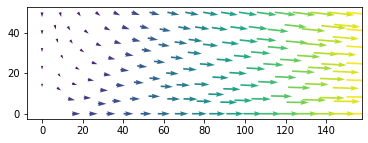

In [33]:
plot(u_fine)

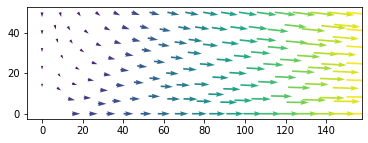

In [34]:
plot(u_coarse)

Extrapolate the coarse mesh displacement to the fine mesh.

In [35]:
u_coarse.set_allow_extrapolation(True)
u_interp_coarse = interpolate(u_coarse,Vfine)

Visualise the difference between the two displacement fields to examine the discretisation error.

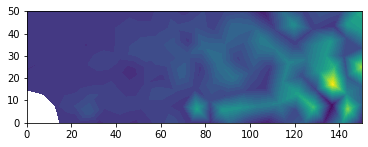

In [36]:
plot(inner(u_fine-u_interp_coarse,u_fine-u_interp_coarse))

Compute the relative norm of error.

In [37]:
u_interp_coarse.set_allow_extrapolation(True)
Error = errornorm(u_fine,u_interp_coarse)
Relativeerror = Error/norm(u_fine)

## Step 8b. Loading and plotting the results

The following briefly demonstrates how to load the results from the Google Drive and compare against the analytical solution. Note that the domain is assumed to be infinite so that the analyical solution is known.

> Do not simply copy and paste the following plots for your report as the following is demonstrative only.

In [38]:
# we define a fine set of horizontal coordinates
x_fine = np.linspace(r+0.01,L,1000)
# we define the analytical prediction for sigma_xx for the infinite plate case
stress_xx_theoretical=np.ones(x_fine.shape[0])-5*r*r/(2*np.power(x_fine,2))+3*np.power(r,4)/(2*np.power(x_fine,4))

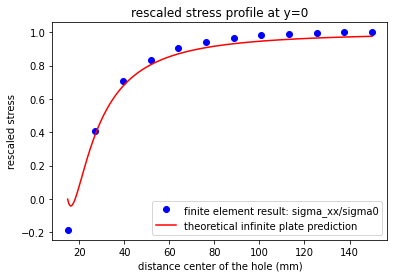

In [39]:
# we plot the analytical solution and the finite element simulation for the rescaled sigma_xx along the bottom boundary of the domain (y=0)
stress_xx = np.loadtxt("stress-xx.txt")
stress_yy = np.loadtxt("stress-yy.txt")
plt.plot(stress_xx[0],stress_xx[1],'bo',label="finite element result: sigma_xx/sigma0")
plt.plot(x_fine,stress_xx_theoretical,'r-',label="theoretical infinite plate prediction")
plt.ylabel("rescaled stress")
plt.xlabel("distance center of the hole (mm)")
plt.title("rescaled stress profile at y=0")
plt.legend()